## In Deep Learning
- Many layers: compositionality
- Convolutions: locality + stationarity of images
- Pooling: Invariance of object class to translations

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# to count the number of parameters
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading the MNIST Dataset

We will use torch functionalities to download the data easily along with some minor pre-processing functions.

In [9]:
input_size = 28 * 28
output_size = 10

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train = True, download = True, 
                                                            transform = transforms.Compose([
                                                                transforms.ToTensor(),
                                                                transforms.Normalize((0.1307,), (0.3081,))
                                                            ])),
                                            batch_size = 64, shuffle = True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train = False, 
                                                            transform = transforms.Compose([
                                                                transforms.ToTensor(),
                                                                transforms.Normalize((0.1307,), (0.3081,))
                                                            ])),
                                            batch_size = 1000, shuffle = True)

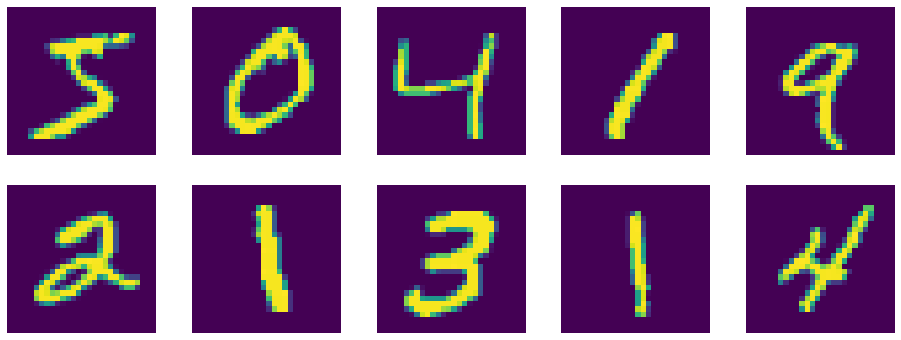

In [10]:
# plotting some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')

## Creating the Model Classes

In [12]:
# Creating a Fully Connected Network
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size) # Flattening the features to feed to the full connected layers
        return self.network(x)

In [13]:
# Creating Convolutinal Network
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_features
        self.conv1 = nn.Conv2d(in_channels= 1 , out_channels= n_feature, kernel_size = 5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size= 5)
        self.fc1 = nn.Linear(n_feature * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose = False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = x.view(-1, self.n_feature * 4 * 4) # Flattening the features to feed to the full connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim = 1)
        return x

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not: